# Languages Dataset

Load languages dataset



In [246]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import hashlib
import numpy as np
from tqdm import tqdm
import pandas as pd
import json
from pprint import pprint

pd.options.mode.chained_assignment = None
# Add the project root to the path to allow importing from `part2`
sys.path.insert(0, os.path.abspath('.'))
from part2.logprobs_cli import get_logprobs

sns.set_theme(style="whitegrid")

In [247]:
splits = {'train': 'train.csv', 'validation': 'valid.csv', 'test': 'test.csv'}

# Requires optional fsspec and huggingface hub dependency; install it with pip install fsspec
df = pd.read_csv("hf://datasets/papluca/language-identification/" + splits["train"])

df.head(10)

,labels,text
0,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,bg,размерът на хоризонталната мрежа може да бъде ...
2,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,ru,Он увеличил давление .
5,pl,"S Jak sobie życzysz: Widzisz, jak Hitler zabij..."
6,ur,اس کے بارے میں ، سفید شادی کی شرح کے بعد سفید ...
7,sw,Zabuni ya ushindani pia imekuwa rahisi kwa sif...
8,tr,Devasa 12 yüzyıl abbatiale saint-Pierre-Et-Sai...
9,ur,موجودہ اثاثوں میں سے ایک کا اضافہ ہو سکتا ہے ۔


In [295]:
# Naive approach, use default models and prompt
prompt_template = """
Given the text below, determine the single most appropriate ISO 639-1 language code based on what language the text is written in. 

Rules:
- Do not explain your answer.
- Do not output any punctuation marks.
- Do not output anything except the ISO 639-1 compliant code.

Text:
{text}

Language code:
"""

# prompt_template = """
# Given the text below, determine the single most appropriate ISO 639 language code as a formatted label LANG_{{ISO_CODE}}

# Rules:
# - Choose exactly one code from the list.
# - Do not explain your answer.
# - Do not output any punctuation marks.
# - Do not output anything except the language label, formatted like LANG_{{ISO_CODE}}

# Text:
# {text}

# Language code:
# """

sample = df.iloc[0]
txt = sample['text']

prompt = prompt_template.format(text=df.iloc[0]['text'])
result = get_logprobs(provider='ollama', model_id='llama3:8b', prompt=prompt, top_logprobs=3, temperature=0, invert_log=False)

# Wrong classification
result.logprobs, sample['labels']

(OrderedDict([('et', -0.188241109251976),
              ('pt', -1.8361293077468872),
              ('lv', -5.697152137756348)]),
 'pt')

In [249]:
# We define two metrics, log margin and entropy, both for logprobs
from scipy.special import logsumexp
from scipy.stats import entropy


def log_margin(logprobs: dict) -> float:
    vals = list(logprobs.values())
    vals.sort(reverse=True)
    return vals[0] - vals[1]



def predictive_entropy(logprobs: dict) -> float:
    """
    Compute predictive entropy from log-probabilities.
    """
    lp = np.array(list(logprobs.values()))

    # Top tokens may have been truncated or have other numerical issues so they no longer sum to 1
    # Normalize in log space (stable)
    log_p = lp - logsumexp(lp)

    # Then convert to probabilities
    p = np.exp(log_p)

    # Entropy is best computed in probability space
    return entropy(p)




In [250]:
# High difference in log values between first and second choice (margin) indicates high certainty / robustness
log_margin(result.logprobs)

6.113433666992933

In [251]:
# Low entropy indicates model's internal certainty
predictive_entropy(result.logprobs)

np.float64(0.02443430398454024)

In [252]:
# Caching helper functions

from diskcache import Cache
import hashlib
import json

cache = Cache("./logprob_cache")

def _make_cache_key(prompt: str, logprob_kwargs: dict) -> str:
    payload = {
        "prompt": prompt,
        "kwargs": logprob_kwargs,
    }
    dumped = json.dumps(payload, sort_keys=True)
    return hashlib.sha256(dumped.encode("utf-8")).hexdigest()


def get_logprobs_cached(prompt: str, **logprob_kwargs):
    key = _make_cache_key(prompt, logprob_kwargs)

    if key in cache:
        return cache[key]

    res = get_logprobs(prompt=prompt, **logprob_kwargs)
    cache[key] = res
    return res


In [266]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def evaluate(df, truncate_len_input=10, **logprob_kwargs):
    preds = []
    logprobs = []
    log_margins = []
    log_entropies = []
    corrects = []
    df = df.copy()
    df['text'] = df['text'].str[:truncate_len_input]

    for _, row in tqdm(df.iterrows(), total=len(df)):
        txt = row['text']

        prompt = prompt_template.format(text=txt)

        res = get_logprobs_cached(prompt=prompt, **logprob_kwargs)
        
        corrects.append(res.response_text == row['labels'])
        preds.append(res.response_text)
        logprobs.append(res.logprobs)

        # metrics
        log_margins.append(log_margin(res.logprobs))
        log_entropies.append(predictive_entropy(res.logprobs))

    df['preds'] = preds
    df['logprobs'] = logprobs
    df['log_margins'] = log_margins
    df['log_entropies'] = log_entropies
    df['correct'] = corrects

    acc = accuracy_score(df['labels'], df['preds'])
    print(f"Accuracty={acc:.3f}")

    print("Errors: ")
    print(df.query('preds != labels')[['labels', 'preds']])

    return df
    # print(res[''])



eval_df = evaluate(df.head(10), provider='ollama', model_id='llama3:8b', top_logprobs=3, temperature=0, truncate_len_input=100, invert_log=False)
eval_df

100%|██████████| 10/10 [00:00<00:00, 1904.34it/s]

Accuracty=0.900
Errors: 
  labels preds
0     pt    et


,labels,text,preds,logprobs,log_margins,log_entropies,correct
0,pt,"os chefes de defesa da estónia, letónia, lituâ...",et,"{'et': -0.006733484100550413, 'pt': -5.8816418...",5.874908,0.027320,False
1,bg,размерът на хоризонталната мрежа може да бъде ...,bg,"{'bg': -0.0031837942078709602, 'ru': -5.996784...",5.993601,0.018844,True
2,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...,zh,"{'zh': -0.000408674735808745, ' zh': -8.223555...",8.223147,0.003137,True
3,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...,th,"{'th': -0.002046088455244899, 'zh': -6.2755732...",6.273527,0.014748,True
4,ru,Он увеличил давление .,ru,"{'ru': -0.0019130907021462917, 'RU': -6.490716...",6.488804,0.013997,True
5,pl,"S Jak sobie życzysz: Widzisz, jak Hitler zabij...",pl,"{'pl': -0.0007971480372361839, 'PL': -7.885314...",7.884518,0.005163,True
6,ur,اس کے بارے میں ، سفید شادی کی شرح کے بعد سفید ...,ur,"{'ur': -0.0010699413251131773, 'urd': -7.94137...",7.940302,0.005415,True
7,sw,Zabuni ya ushindani pia imekuwa rahisi kwa sif...,sw,"{'sw': -0.041259922087192535, 'sv': -3.2700426...",3.228783,0.171951,True
8,tr,Devasa 12 yüzyıl abbatiale saint-Pierre-Et-Sai...,tr,"{'tr': -0.1628260761499405, 'fr': -1.906997203...",1.744171,0.426949,True
9,ur,موجودہ اثاثوں میں سے ایک کا اضافہ ہو سکتا ہے ۔,ur,"{'ur': -0.005191076081246138, 'fa': -6.8903989...",6.885208,0.014574,True


In [267]:
# Very certain mistakes!
eval_df.sort_values(by='log_margins', ascending=False).query('~correct')

,labels,text,preds,logprobs,log_margins,log_entropies,correct
0,pt,"os chefes de defesa da estónia, letónia, lituâ...",et,"{'et': -0.006733484100550413, 'pt': -5.8816418...",5.874908,0.02732,False


In [268]:
truncate_lens = [1, 5, 25, 100]

N = 100

dfs = []

for tlen in truncate_lens:
    eval_df = evaluate(df.head(N), provider='ollama', model_id='llama3:8b', top_logprobs=3, temperature=0, truncate_len_input=tlen)
    eval_df['context_length'] = tlen
    dfs.append(eval_df)

100%|██████████| 100/100 [00:00<00:00, 3158.96it/s]


Accuracty=0.360
Errors: 
   labels preds
0      pt    es
1      bg    ru
5      pl    es
6      ur    ar
7      sw    zh
..    ...   ...
93     bg    ru
95     vi    hu
97     de    ru
98     ur    ar
99     de    da

[64 rows x 2 columns]


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


Accuracty=0.650
Errors: 
   labels preds
1      bg    ru
5      pl    sl
7      sw    ar
8      tr    ta
9      ur    fa
11     es    fr
13     it    es
21     pt    es
22     sw    mi
24     nl    pt
27     bg    ru
28     th    ja
31     pt    es
32     de    fr
33     pt    uk
41     es    fr
45     pl    fr
47     nl    hu
53     it    fr
60     it    el
65     bg    ru
67     vi    fr
68     sw    fr
73     sw    kw
74     sw    kw
76     nl    de
77     bg    ru
81     ur    ar
82     en    it
84     nl    de
85     it    fr
93     bg    ru
96     ru    uk
97     de    et
98     ur    fa


100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


Accuracty=0.950
Errors: 
   labels preds
1      bg    ru
22     sw    nd
33     pt    uk
65     bg    uk
93     bg    ru


100%|██████████| 100/100 [00:00<00:00, 2595.66it/s]

Accuracty=0.930
Errors: 
   labels preds
0      pt    et
8      tr    fr
22     sw    nd
33     pt    uk
63     vi    en
70     pl    ar
73     sw    fr


In [270]:
eval_df = pd.concat(dfs)
eval_df

,labels,text,preds,logprobs,log_margins,log_entropies,correct,context_length
0,pt,o,es,"{'en': 0.3468864927517048, 'es': 0.23302009428...",0.113866,1.094990,False,1
1,bg,р,ru,"{'ru': 0.9983515412379427, 'RU': 0.00127224143...",0.997079,0.975907,False,1
2,zh,很,zh,"{'zh': 0.9990625627954028, ' zh': 0.0003896159...",0.998673,0.975641,True,1
3,th,ส,th,"{'th': 0.9991996419510083, 'tha': 0.0007153707...",0.998484,0.975612,True,1
4,ru,О,ru,"{'ru': 0.9975537938008943, 'RU': 0.00202676770...",0.995527,0.976198,True,1
...,...,...,...,...,...,...,...,...
95,vi,Họ cho tôi ăn thịt chim và một cái rêu lớn lên...,vi,"{'vi': 0.9920920530456229, 'vn': 0.00729163714...",0.984800,0.978168,True,100
96,ru,"У меня есть кое-что , что я не знаю , я даже н...",ru,"{'ru': 0.9984302884971458, 'RU': 0.00110005762...",0.997330,0.975872,True,100
97,de,Ränder liegen frei wodurch leicht Risse entste...,de,"{'de': 0.9999066191832358, 'DE': 6.19775788817...",0.999845,0.975359,True,100
98,ur,لیکن میرے والدین کو یہ پسند نہیں ہے .,ur,"{'ur': 0.9959738381171046, 'urd': 0.0009225319...",0.995051,0.976532,True,100


In [271]:
eval_df.groupby("context_length").size()

context_length
1      100
5      100
25     100
100    100
dtype: int64

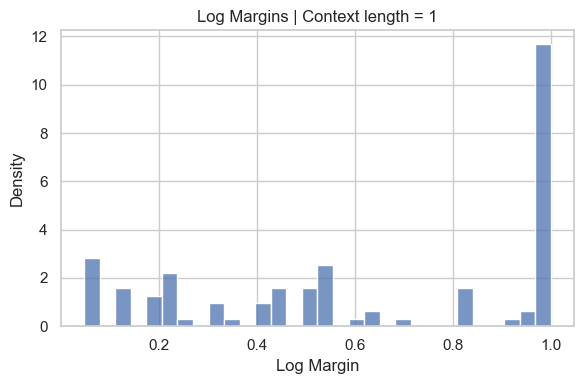

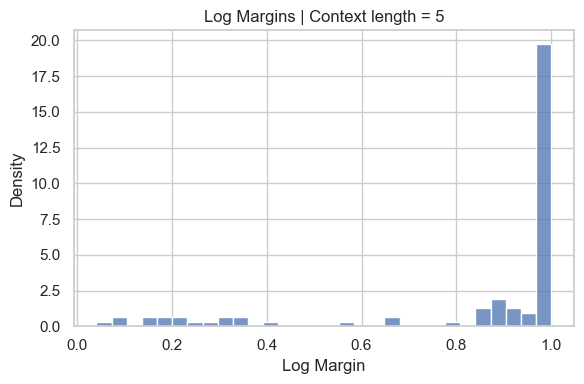

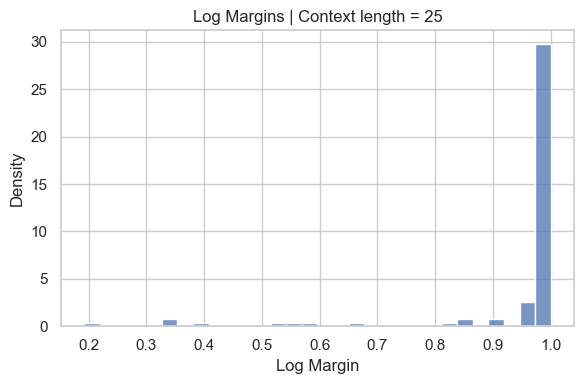

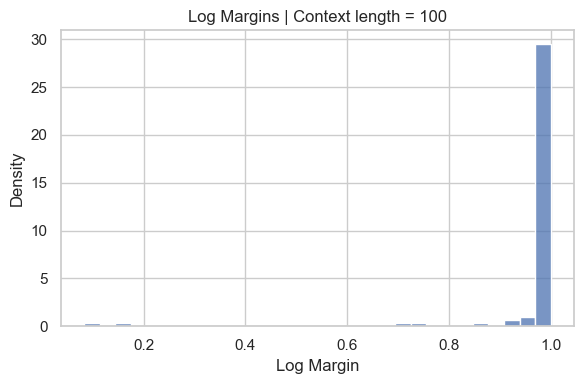

In [272]:
for ctx in eval_df["context_length"].unique():
    # print(ctx)
    plt.figure(figsize=(6, 4))

    sns.histplot(
        data=eval_df[eval_df["context_length"] == ctx],
        x="log_margins",
        bins=30,
        stat="density",
        common_norm=True,
        
    )

    plt.title(f"Log Margins | Context length = {ctx}")
    plt.xlabel("Log Margin")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


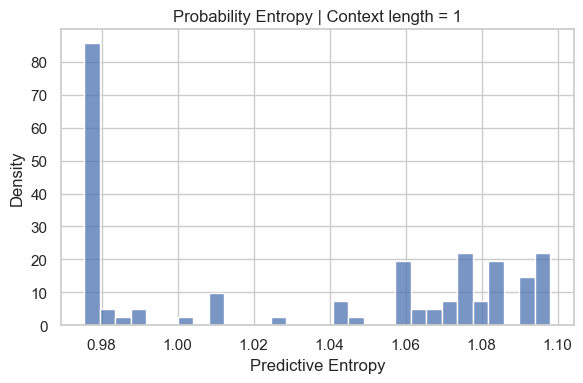

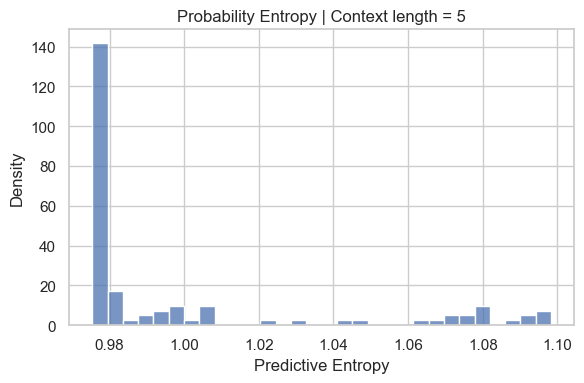

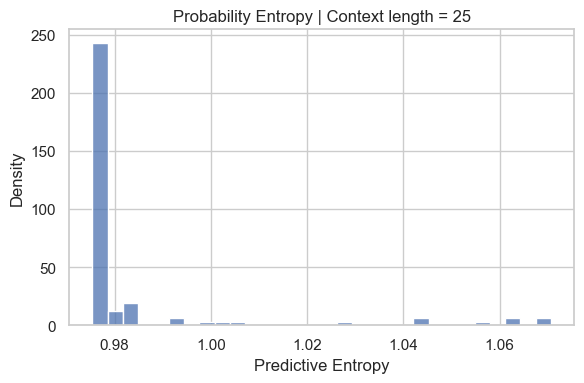

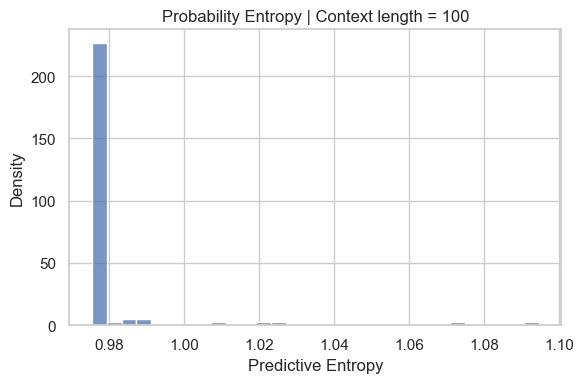

In [273]:
for ctx in eval_df["context_length"].unique():
    # print(ctx)
    plt.figure(figsize=(6, 4))

    sns.histplot(
        data=eval_df[eval_df["context_length"] == ctx],
        x="log_entropies",
        bins=30,
        stat="density",
        common_norm=True,
        
    )

    plt.title(f"Probability Entropy | Context length = {ctx}")
    plt.xlabel("Predictive Entropy")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


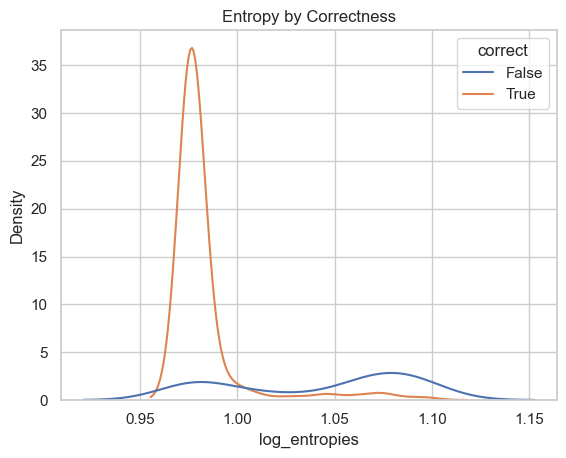

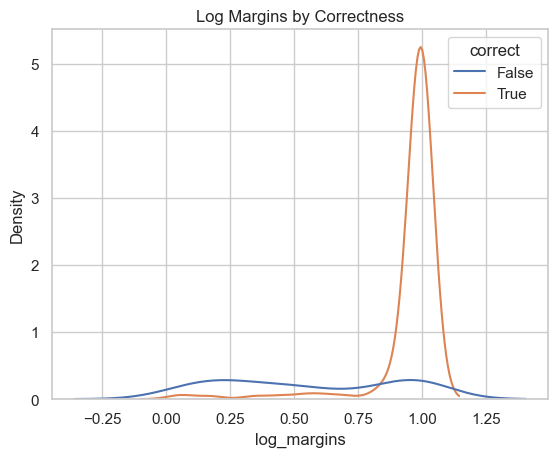

In [280]:
sns.kdeplot(
    data=eval_df,
    x="log_entropies",
    hue="correct",
    
    # stat="density",
    # common_norm=False,
    # element="step"
).set_title("Entropy by Correctness")
plt.show()
sns.kdeplot(
    data=eval_df,
    x="log_margins",
    hue="correct",
    
    # stat="density",
    # common_norm=False,
    # element="step"
).set_title("Log Margins by Correctness");

<Axes: xlabel='log_margins', ylabel='log_entropies'>

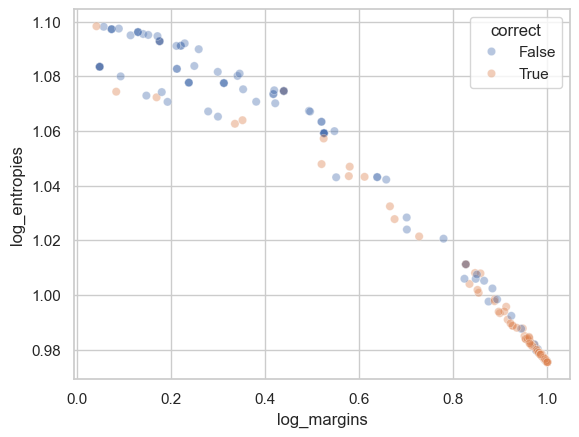

In [281]:
sns.scatterplot(
    data=eval_df,
    x="log_margins",
    y="log_entropies",
    hue="correct",
    alpha=0.4
)


In [ ]:
# Correct but high entropy
pd.set_option('display.max_colwidth', 120)

cols_of_interest = ['labels', 'preds', 'text', 'log_margins', 'log_entropies']

eval
eval_df.query("correct").query("context_length == 100").sort_values(by='log_entropies', ascending=False)

,labels,text,preds,logprobs,log_margins,log_entropies,correct,context_length
74,sw,Kwa paka anyway unajua vizuri usikie it ' s been a pleasure talking to you,sw,"{'sw': 0.5380346065174159, 'en': 0.45466255053127674, 'sv': 0.004615779863643884}",0.083372,1.074360,True,100
65,bg,на демократична конвенция обаче остави макгавърн а след това досие 23 точки в дупката .,bg,"{'bg': 0.8580804952306739, 'ru': 0.1307782150852024, 'mk': 0.006956378599186455}",0.727302,1.021399,True,100
7,sw,"Zabuni ya ushindani pia imekuwa rahisi kwa sifa ya kurudi kwenye mapendekezo yake ya grant , na dudo",sw,"{'sw': 0.9595796815769697, 'sv': 0.03800480583720604, 'Sw': 0.0013566259337688192}",0.921575,0.989590,True,100
53,it,L'India e il Pakistan rimangono fuori dal trattato.,it,"{'it': 0.9619086368562471, 'en': 0.026936338462928026, 'hi': 0.0029271516777017283}",0.934972,0.987966,True,100
21,pt,Jactos do exército matam 38 militantes em ataques aéreos no Noroeste do Paquistão,pt,"{'pt': 0.9724846983627825, 'ur': 0.01153459235362023, 'ps': 0.010747055238953992}",0.960950,0.984611,True,100
...,...,...,...,...,...,...,...,...
26,es,"Casco para decoración. No homologado y poco más que un casco de juguete, si tienes un accidente es m",es,"{'es': 0.9999125078689362, 'ES': 7.407197877657918e-05, 'Es': 4.321880316029923e-06}",0.999838,0.975359,True,100
64,es,"No sirve para nada, mala adherencia, material muy debil",es,"{'es': 0.9999113994816676, 'ES': 6.489652966123146e-05, 'sp': 9.322005744015662e-06}",0.999847,0.975359,True,100
34,fr,J'ai beaucoup ce livre cependant je n'ai pas mis 5 étoiles car au début j'ai eu du mal à m'associer,fr,"{'fr': 0.9999224522200297, 'fra': 5.671734224120796e-05, 'FR': 4.143840596525137e-06}",0.999866,0.975354,True,100
30,fr,Le produit m'avait été recommandé par mon pharmacien pour ralentir le développement de mon arthrose.,fr,"{'fr': 0.9999216908576778, 'FR': 3.6968007283376175e-05, 'fra': 1.829256882878233e-05}",0.999885,0.975354,True,100


# Experiment 2: Multi-class Classification

[Explain]

First mix and match different samples.

In [294]:
import random
import string


def add_text_noise(
    text: str,
    noise_prob: float = 0.0,
    delete_prob: float = 0.33,
    swap_prob: float = 0.33,
    replace_prob: float = 0.34,
    alphabet: str = string.ascii_lowercase + string.ascii_uppercase
) -> str:
    """
    Add character-level noise to a string.
    Noise operations:
      - delete a character
      - swap with next character
      - replace with random character
    """
    if noise_prob <= 0.0:
        return text

    chars = list(text)
    i = 0

    while i < len(chars):
        if random.random() < noise_prob:
            r = random.random()

            # delete
            if r < delete_prob:
                chars.pop(i)
                continue

            # swap
            elif r < delete_prob + swap_prob and i < len(chars) - 1:
                chars[i], chars[i + 1] = chars[i + 1], chars[i]
                i += 2
                continue

            # replace
            else:
                chars[i] = random.choice(alphabet)

        i += 1

    return "".join(chars)


def generate_mixed_samples(
    df: pd.DataFrame,
    min_texts: int = 1,
    max_texts: int = 5,
    noise_prob: float = 0.0,
    shuffle: bool = True,
    label_sep: str = "|"
) -> pd.DataFrame:
    """
    Generate mixed text samples without replacement.

    Returns a dataframe with columns:
      - text
      - label
    """

    assert {"text", "labels"}.issubset(df.columns)

    indices = list(df.index)
    if shuffle:
        random.shuffle(indices)

    samples = []
    used = set()
    i = 0

    while i < len(indices):
        if indices[i] in used:
            i += 1
            continue

        k = random.randint(min_texts, max_texts)
        chosen = []

        for idx in indices[i:]:
            if idx not in used:
                chosen.append(idx)
            if len(chosen) == k:
                break

        if len(chosen) == 0:
            break

        # mark as used
        for idx in chosen:
            used.add(idx)

        texts = df.loc[chosen, "text"].tolist()
        labels = df.loc[chosen, "labels"].tolist()

        combined_text = " ".join(texts)
        combined_text = add_text_noise(combined_text, noise_prob=noise_prob)

        # order-invariant multiclass label
        combined_label = label_sep.join(sorted(map(str, labels)))

        samples.append((combined_text, combined_label))

        i += len(chosen)

    return pd.DataFrame(samples, columns=["text", "labels"])


generate_mixed_samples(df.head(1000))

,text,labels
0,"Qualité médiocre Ne prend pas deux casques Une fois appareiller, le son est transmis d’un seul côté. Je déconseille ...",fr|pt
1,"Oh yaaa sence Я не знаю , слышал ли ты хоть что-нибудь об этом в новостях в последнее время или нет , но пару месяце...",it|nl|ru|tr
2,根本不是亚马逊销售和发货，商品页面还写什么“由亚马逊直接销售和发货” 亚马逊是不知道“直接”是什么意思吗？ 商品页面写的是意大利制造，条码标签上印着“MADE IN CHINA” 亚马逊您这是刻意隐瞒？还是故意欺骗消费者？ Nie ...,pl|zh
3,Biały pies biegający przez śnieg نظام شمسی کے ليے اسٹر ئٹجي امتراج پر عمل شروع کیا گیا تھا جس کی وجہ سے طرزیاتی ابلا...,en|pl|ru|ur
4,"Έχω κάνει τέσσερις ή πέντε . Πρώτον , πρόκειται για πρόγραμμα αποταμίευσης ; Sijui kama umesikia yoyote lakini yoyot...",el|el|sw
...,...,...
334,คุณ ไม่ต้อง แกล้ง ว่า คุณ ไม่ใช่ اس کے علاوہ دوسرے جانوروں کا بھی تعلق ہے ۔ मुख ् य वित ् तीय अधिकारी ( cfo ) अधिनिय...,hi|ru|th|ur
335,二度目の交換です。数年前に一度折れ、ドコモショップにて交換。更に今回またピンが折れ今回です。さすがはAmazon、四年前モデルですがありますね。しかしながら、最初に届いた品物のSIMカード側カバーのピンが折れていました。おそらくは郵...,fr|ja|ru
336,"макар да признава , че изграждането на новата програма от земята е бавно , dudovitz очаква да служи до 30 % повече к...",bg|el|pt|tr
337,A4横に入れた場合、クリアファイルが付くと入れにくく厳しい。あと2センチ大きいとイイネ。 Een man speelt op een houten fluit terwijl verschillende andere mannen ...,ja|nl


In [ ]:
# Naive approach is to ask for multiple labels

prompt_template = """
Given the text below, determine the most appropriate ISO 639-1 language codes for the text based on the language the text was written in.

Rules:
- Choose one or more codes
- If multiple languages found, output the codes in a comma separate output (i.e. "en,fr")
- Do not explain your answer.
- Do not output anything except the ISO codes.

Text:
{text}

Language code:
"""

prompt_template

result = get_logprobs(provider='ollama', model_id='llama3:8b', prompt=prompt, top_logprobs=3, temperature=0, invert_log=False)